In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/My Drive/UNICC/Final

/content/drive/My Drive/UNICC/Final


In [22]:
ls

bin/      datalab/  home/   lib64/  opt/   run/   sys/                tools/
boot/     dev/      lib/    media/  proc/  sbin/  tensorflow-1.15.2/  usr/
content/  etc/      lib32/  mnt/    root/  srv/   tmp/                var/


In [3]:
from matplotlib import pyplot as plt
import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns
import numpy as np

from sklearn.metrics import r2_score,adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
xl = pd.ExcelFile("Dashboard.xlsx")
xl.sheet_names
df_final = xl.parse("Training Data")
df_final.tail()

,Country,Year,Exchange Rate,GDP per Capita,Battle-related deaths,Intentional homicides,School enrollment,Life expectancy at birth,Hospital beds,Fertility rate,Child Mortality rate,Urban population growth,Population density,Foreign direct investment,Unemployment,Refugees,Asylum Seekers,Internal Displacement
95,Iraq,2015,1167.333333,4989.803075,10138,0.0,92.267405,69.929,1.380000,3.972000,29.5,3.549616,81.939569,7.721900e+09,10.72,264086,237168,4403287
96,Iraq,2016,1182.000000,4777.197619,9622,0.0,92.267405,70.122,1.300000,3.864000,28.6,3.124368,84.331423,6.560200e+09,10.82,316056,278367,3604285
97,Iraq,2017,1184.000000,5205.288255,10211,0.0,92.267405,70.294,1.320000,3.762000,27.7,2.803035,86.501633,5.110200e+09,13.02,362536,272627,2615988
98,Iraq,2018,1182.750000,5834.166211,1252,0.0,92.267405,70.454,1.302778,3.672000,26.8,2.595551,88.530572,5.073500e+09,12.87,372332,256716,1802832
99,Iraq,2019,1182.000000,5955.109010,752,0.0,92.267405,70.614,1.308488,4.339474,25.9,2.544602,69.168858,3.269800e+09,12.76,336274,303429,1414632


In [5]:
def adj_r2(x, ans, y_test):  
  r2 = r2_score(ans, y_test)
  print('R2 = ',r2)
  n = x.shape[0] 
  p = x.shape[1]
  adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
  return adjusted_r2

In [6]:
def plot_feature_importance(importance,names,model_type):
  
  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)
  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)
  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
  #Define size of bar plot
  plt.figure(figsize=(10,8))
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  #Add chart labels
  plt.title(model_type)
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')
  #show_figure(plt)
  plt.show()

In [12]:
def model_imp(df_final,country, target_feature_list):
  df_final = df_final[df_final['Country'] == country]
  
  corr = df_final.corr()
  print(sns.heatmap(corr))
  plt.show()
  print(df_final.columns)
  df_copy = df_final.copy()
  for target_feature in target_feature_list:
    df = df_copy[['Exchange Rate', 'GDP per Capita',
       'Battle-related deaths', 'Intentional homicides', 'School enrollment',
       'Life expectancy at birth', 'Hospital beds', 'Fertility rate',
       'Child Mortality rate', 'Urban population growth', 'Population density',
       'Foreign direct investment', 'Unemployment', 
       target_feature]]
    
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    
    X = X.apply(pd.to_numeric, errors='coerce')
    y = y.apply(pd.to_numeric, errors='coerce')
    X.fillna(0, inplace=True)
    y.fillna(0, inplace=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
    
    regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
    tree_reg = regressor.fit(X, y)
    ans = regressor.predict(X_test)
    
    
    plot_feature_importance(regressor.feature_importances_,X.columns,'Random Forest Feature Importance for ' + target_feature)
    
    ansadjr2 = adj_r2(X_test,ans, y_test)
    print('Adjusted R2 = ',ansadjr2)
    df_new = xl.parse("Prediction Data")
    df_new = df_new[df_new['Country'] == country]
    df_new_pred = df_new.iloc[:,2:]
    df_new_pred_ans= regressor.predict(df_new_pred)
    print(df_new_pred_ans)
    if target_feature == 'Refugees':
      refugees = df_new_pred_ans
    elif target_feature == 'Asylum Seekers':
      asylum_seekers = df_new_pred_ans
    elif target_feature == 'Internal Displacement':
      IDPs = df_new_pred_ans
  year = [y for y in range(2020,2026)]
  final_ans = pd.DataFrame({
                    'Refugees' : refugees,
                    'Asylum Seekers' : asylum_seekers,
                    'Internal Displacement' : IDPs})
  final_ans['displaced'] = final_ans.iloc[:,-3:].sum(axis=1)
  final_ans['Year'] =  [y for y in range(2020,2026)]
  final_ans = final_ans[['Year', 'Refugees', 'Asylum Seekers',
        'Internal Displacement', 'displaced']]
  final_ans.to_csv(country+'_results.csv')

  return country+'_results.csv'


In [8]:
def get_forecast_graphs(df_input, country, df_output, target_feature_list):

  df_input = df_input[df_input['Country'] == country]
  df_input = df_input[df_input['Year']<2020]
  df_input['displaced'] = df_input.iloc[:,-3:].sum(axis=1)

  new_feature_list = target_feature_list + ['displaced']

  last_row = df_input[df_input['Year']==2019]
  df_temp = pd.DataFrame({"Year": 2019, 
                          new_feature_list[0]: last_row[target_feature_list[0]], 
                          new_feature_list[1]: last_row[target_feature_list[1]], 
                          new_feature_list[2]: last_row[target_feature_list[2]], 
                          new_feature_list[3]: last_row[target_feature_list[0]]+last_row[target_feature_list[1]]+last_row[target_feature_list[2]]})
  df = pd.concat([df_temp, df_output]).reset_index(drop = True) 

  for i in new_feature_list:
    plt.plot('Year', i, data=df_input)
    plt.plot('Year', i, data=df, linestyle="dashed")
    plt.xlabel('Year')
    plt.xticks(rotation = 45)
    plt.ylabel(i)
    plt.legend(["Actual", "Forecasted"])
    plt.show()

Afghanistan
AxesSubplot(0.125,0.125;0.62x0.755)


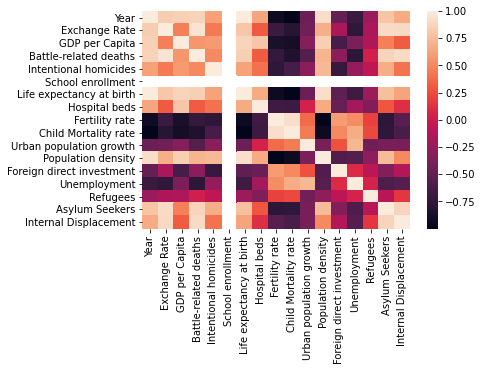

Index(['Country', 'Year', 'Exchange Rate', 'GDP per Capita',
       'Battle-related deaths', 'Intentional homicides', 'School enrollment',
       'Life expectancy at birth', 'Hospital beds', 'Fertility rate',
       'Child Mortality rate', 'Urban population growth', 'Population density',
       'Foreign direct investment', 'Unemployment', 'Refugees',
       'Asylum Seekers', 'Internal Displacement'],
      dtype='object')
R2 =  -23.621893545548044
Adjusted R2 =  8.386568063664413


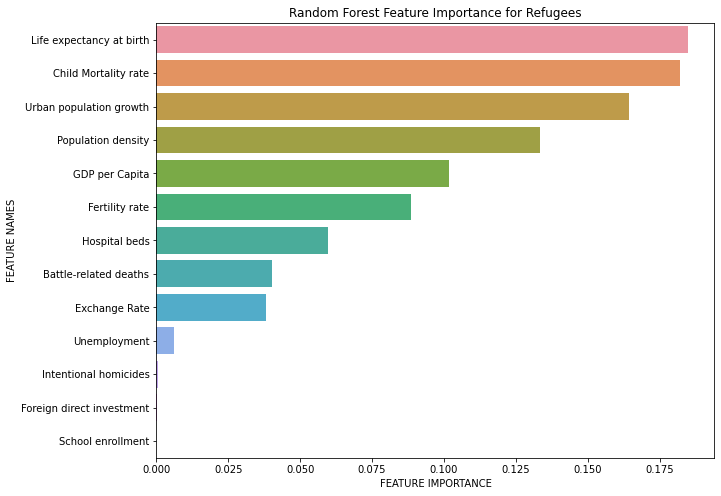

[2695837.2 2695837.2 2695837.2 2695837.2 2695837.2 2695837.2]
R2 =  0.9322498896285198
Adjusted R2 =  1.020325033111444


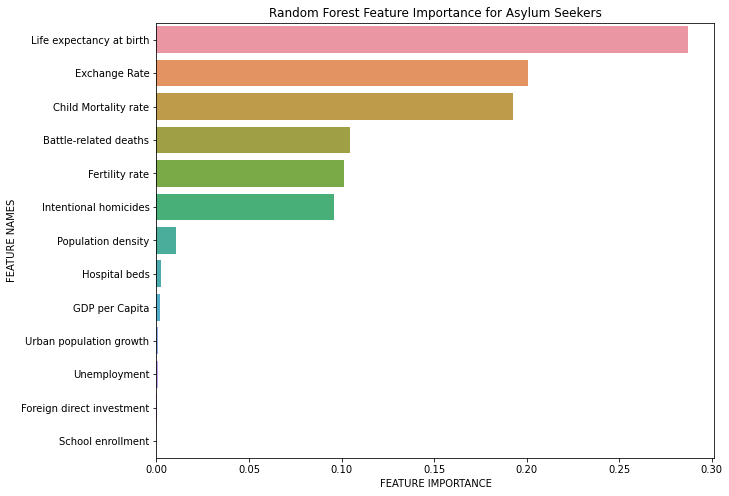

[261416.9 261416.9 288585.1 288585.1 288585.1 294071.4]
R2 =  -1.1158903527689277
Adjusted R2 =  1.6347671058306783


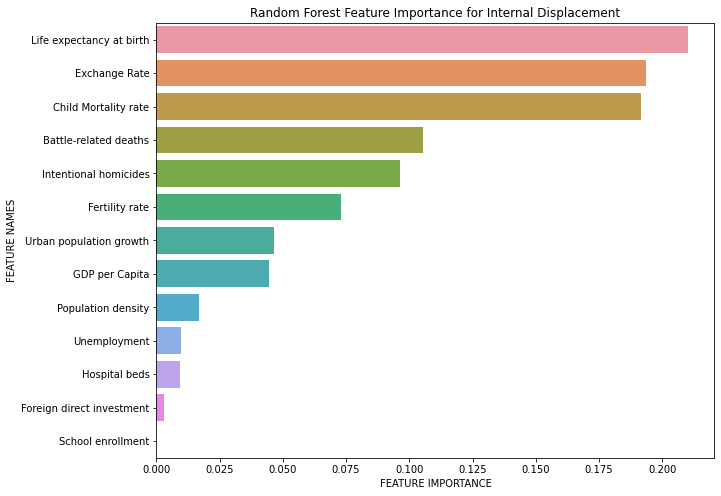

[2060315.3 2060315.3 2214310.3 2214310.3 2214310.3 2214310.3]
Model Results


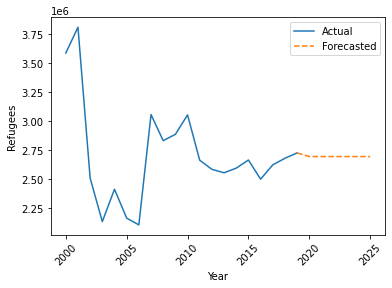

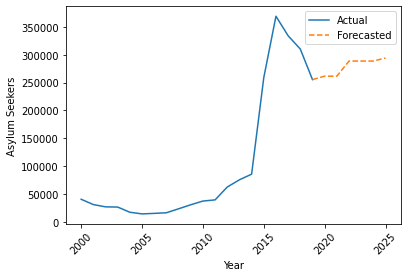

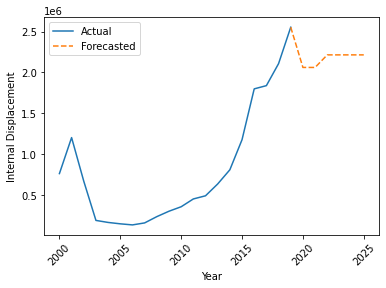

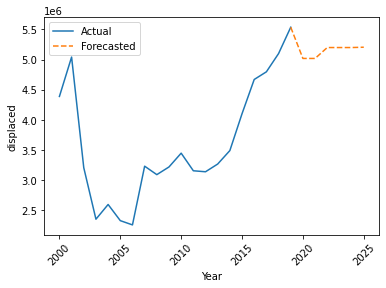

Iraq
AxesSubplot(0.125,0.125;0.62x0.755)


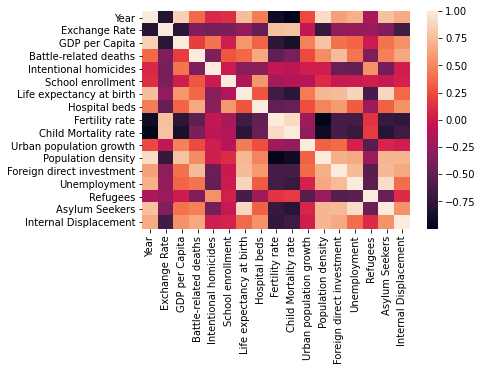

Index(['Country', 'Year', 'Exchange Rate', 'GDP per Capita',
       'Battle-related deaths', 'Intentional homicides', 'School enrollment',
       'Life expectancy at birth', 'Hospital beds', 'Fertility rate',
       'Child Mortality rate', 'Urban population growth', 'Population density',
       'Foreign direct investment', 'Unemployment', 'Refugees',
       'Asylum Seekers', 'Internal Displacement'],
      dtype='object')
R2 =  0.94283783132193
Adjusted R2 =  1.017148650603421


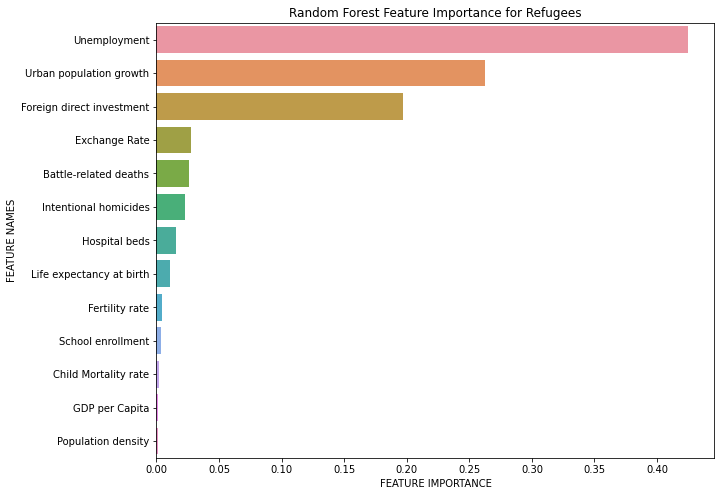

[346751.3 336489.7 336489.7 336252.5 335510.1 335510.1]
R2 =  0.39379244904451094
Adjusted R2 =  1.1818622652866466


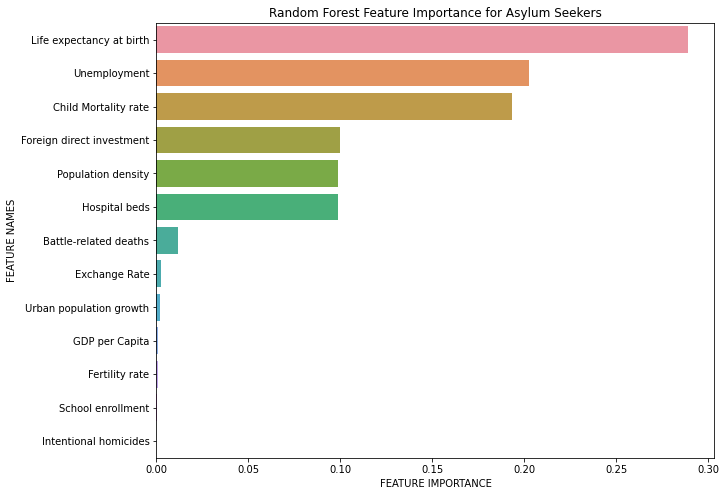

[259381.1 259955.1 258000.3 258000.3 258000.3 259591.4]
R2 =  0.6544228918902536
Adjusted R2 =  1.1036731324329239


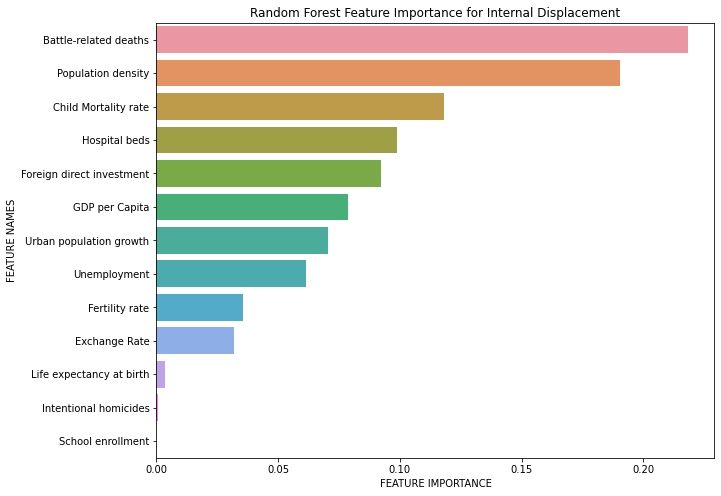

[2626588.5 2730916.4 2824775.9 2990961.9 2990961.9 2990961.9]
Model Results


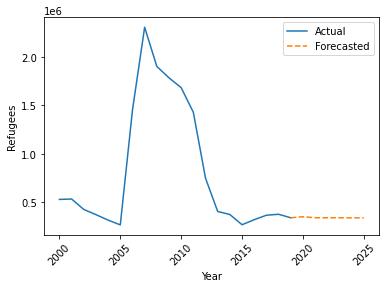

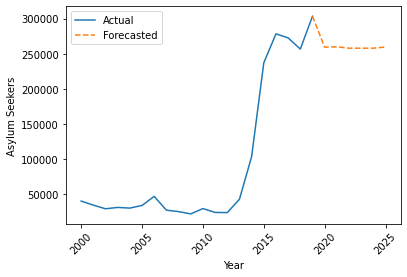

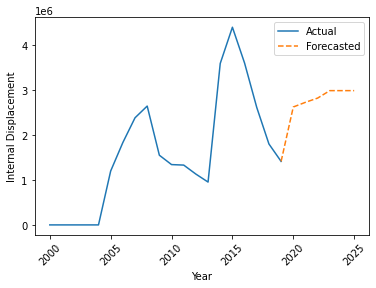

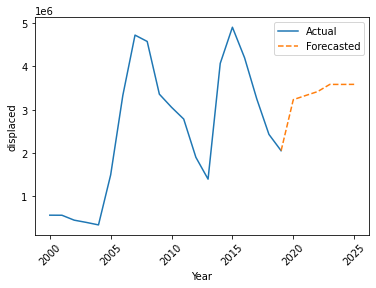

Syrian Arab Republic
AxesSubplot(0.125,0.125;0.62x0.755)


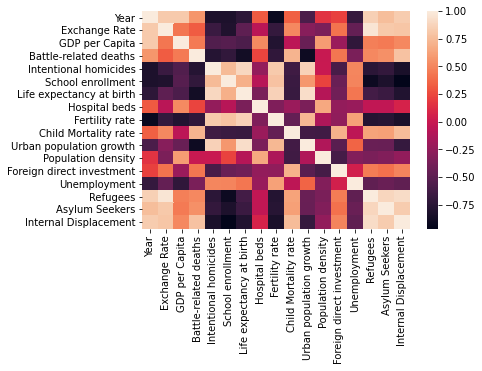

Index(['Country', 'Year', 'Exchange Rate', 'GDP per Capita',
       'Battle-related deaths', 'Intentional homicides', 'School enrollment',
       'Life expectancy at birth', 'Hospital beds', 'Fertility rate',
       'Child Mortality rate', 'Urban population growth', 'Population density',
       'Foreign direct investment', 'Unemployment', 'Refugees',
       'Asylum Seekers', 'Internal Displacement'],
      dtype='object')
R2 =  0.799182652068094
Adjusted R2 =  1.0602452043795718


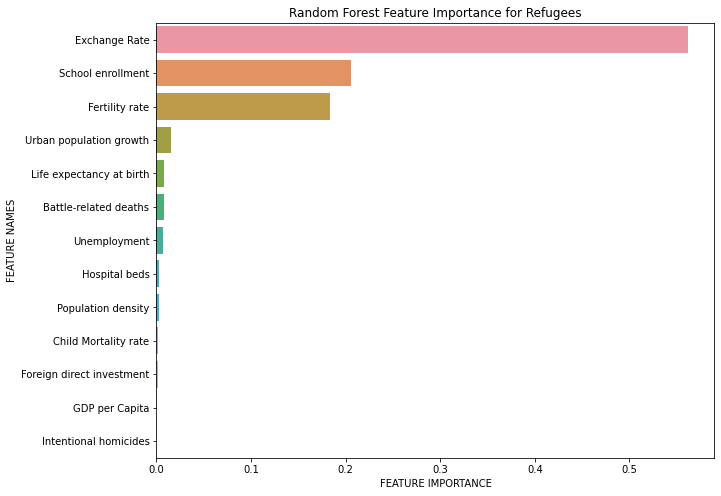

[5142305.4 4968104.1 5142035.2 5447654.  5866259.1 5831871.5]
R2 =  0.9688485530729188
Adjusted R2 =  1.0093454340781243


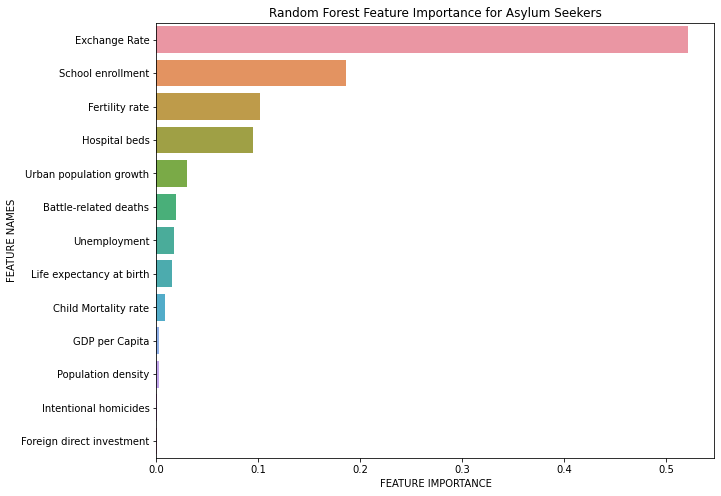

[130904.7 134032.7 134032.7 134032.7 143888.4 144648.7]
R2 =  0.7268901383170531
Adjusted R2 =  1.081932958504884


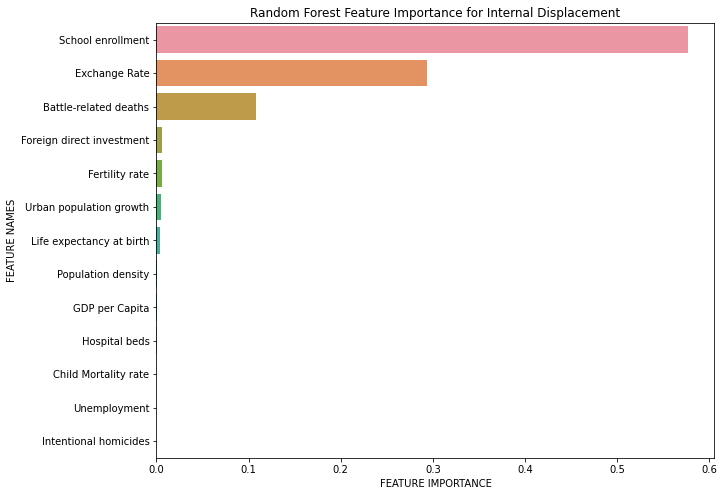

[6453326.9 6490707.5 6490707.5 6490707.5 6494973.7 6528661.7]
Model Results


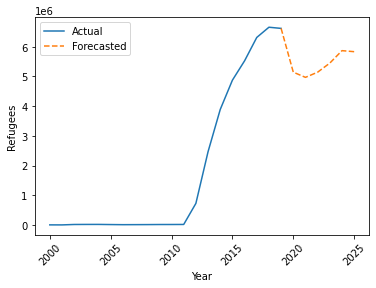

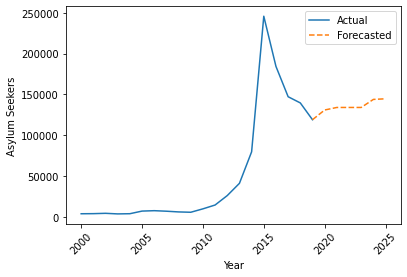

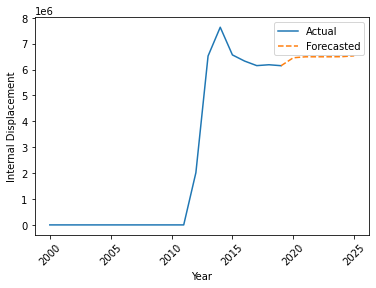

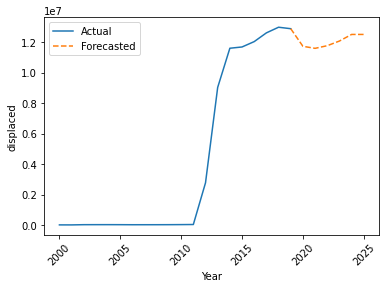

Congo, Dem. Rep.
AxesSubplot(0.125,0.125;0.62x0.755)


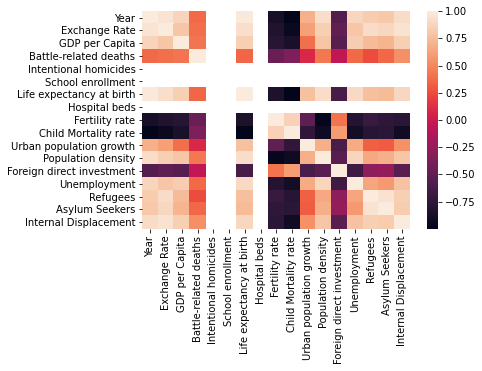

Index(['Country', 'Year', 'Exchange Rate', 'GDP per Capita',
       'Battle-related deaths', 'Intentional homicides', 'School enrollment',
       'Life expectancy at birth', 'Hospital beds', 'Fertility rate',
       'Child Mortality rate', 'Urban population growth', 'Population density',
       'Foreign direct investment', 'Unemployment', 'Refugees',
       'Asylum Seekers', 'Internal Displacement'],
      dtype='object')
R2 =  -1.0533735483569395
Adjusted R2 =  1.616012064507082


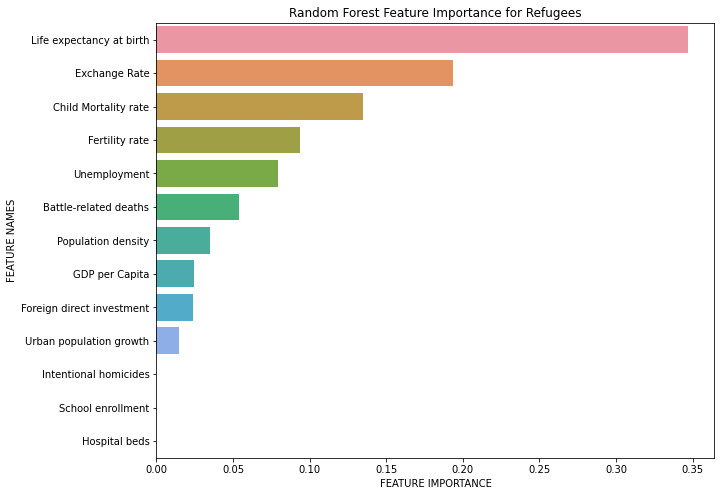

[685752.8 685752.8 685752.8 685752.8 706855.5 706855.5]
R2 =  0.0010429560951145112
Adjusted R2 =  1.2996871131714656


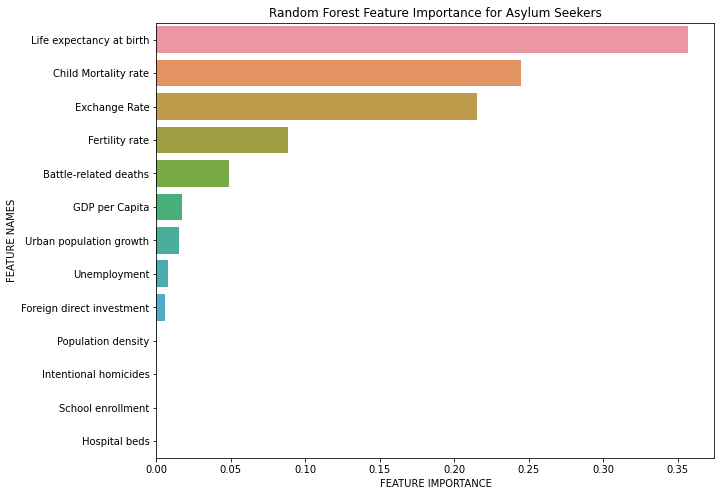

[126818.2 126818.2 126818.2 126545.2 126545.2 126545.2]
R2 =  -0.25104923120161504
Adjusted R2 =  1.3753147693604846


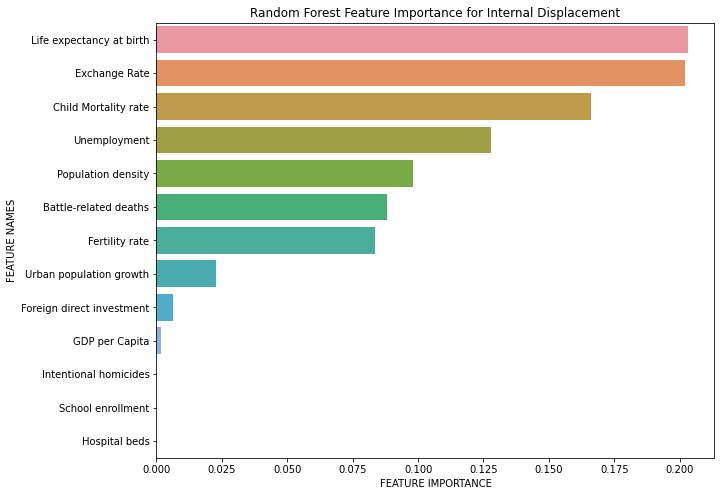

[3678673.1 3941672.5 3662046.1 3662046.1 3488717.1 3888473. ]
Model Results


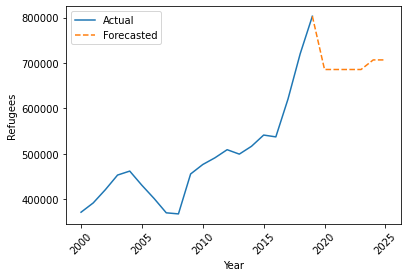

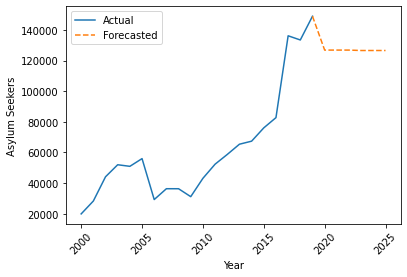

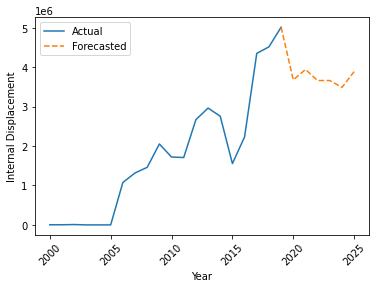

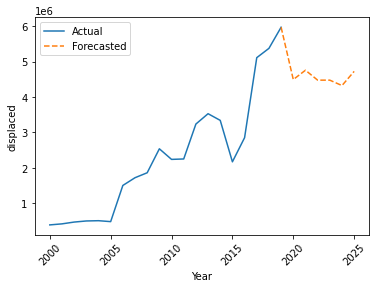

Colombia
AxesSubplot(0.125,0.125;0.62x0.755)


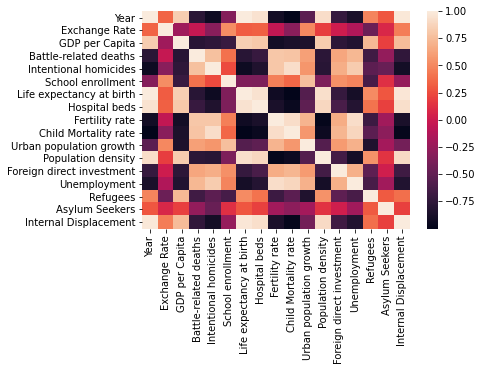

Index(['Country', 'Year', 'Exchange Rate', 'GDP per Capita',
       'Battle-related deaths', 'Intentional homicides', 'School enrollment',
       'Life expectancy at birth', 'Hospital beds', 'Fertility rate',
       'Child Mortality rate', 'Urban population growth', 'Population density',
       'Foreign direct investment', 'Unemployment', 'Refugees',
       'Asylum Seekers', 'Internal Displacement'],
      dtype='object')
R2 =  0.6173412027164935
Adjusted R2 =  1.114797639185052


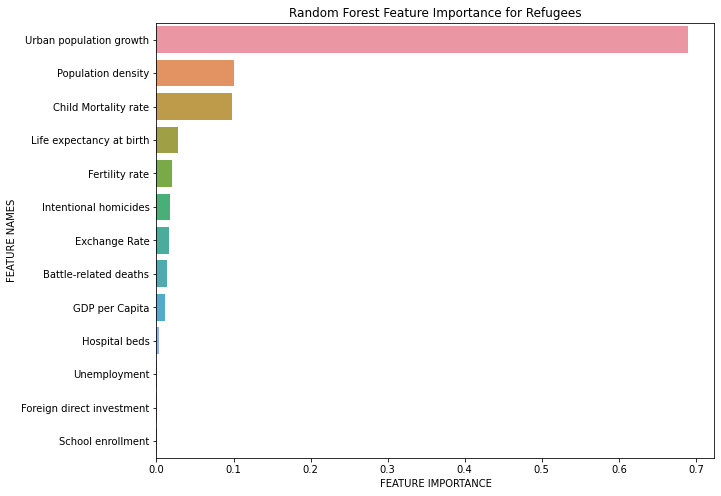

[345399.9 345872.8 345986.  346421.8 346421.8 342855.9]
R2 =  -4.209419634184335
Adjusted R2 =  2.5628258902553003


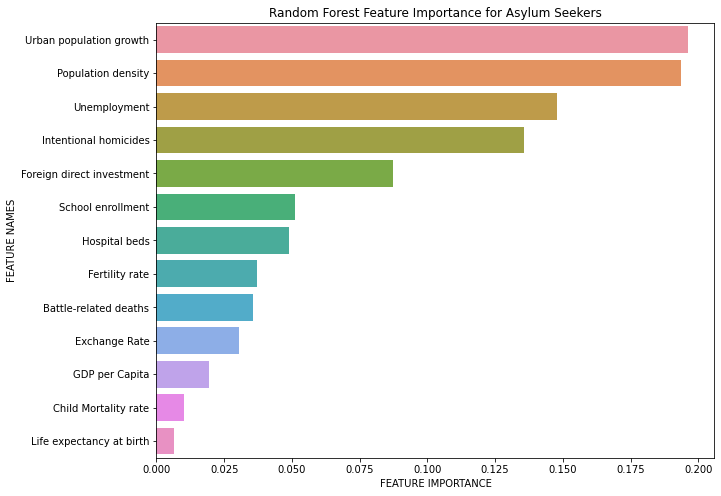

[57073.5 48327.4 36497.2 32188.6 25103.5 25103.5]
R2 =  0.607909828674668
Adjusted R2 =  1.1176270513975997


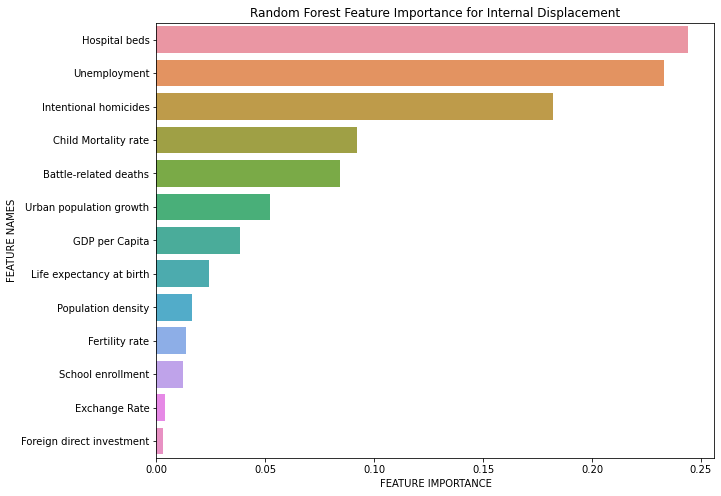

[6538557.3 7190208.9 6819750.6 6819750.6 6819750.6 6803756.7]
Model Results


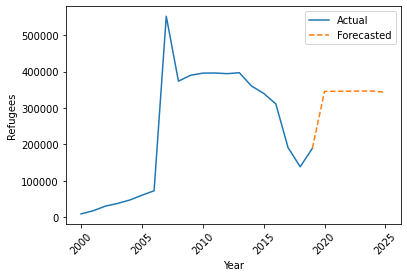

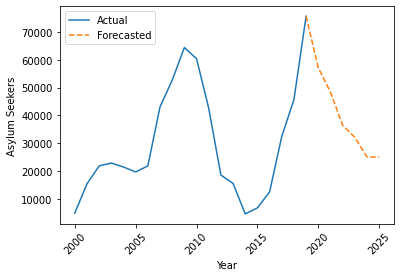

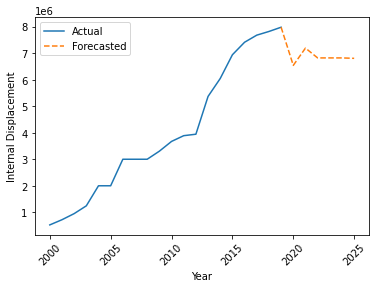

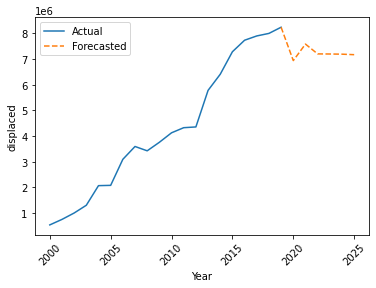

In [13]:
country_list = ['Afghanistan', 'Iraq', 'Syrian Arab Republic', 'Congo, Dem. Rep.', 'Colombia']
target_feature_list = ['Refugees', 'Asylum Seekers', 'Internal Displacement']

for country in country_list:
  print(country)
  result_csv_file = model_imp(df_final, country, target_feature_list)
  
  print("Model Results")
  df_results = pd.read_csv(result_csv_file, index_col=0)
  get_forecast_graphs(df_final, country, df_results, target_feature_list)

/content/drive/My Drive/UNICC/Final


In [ ]:
ls

 Afghanistan_results.csv                 Final_results_graphs.ipynb
 Afghanistan.xlsx                        GearShiftersNB.ipynb
 AGF_Pred_V2.csv                         Iraq_results.csv
 Colombia_results.csv                    nyt_asylum.csv
'Congo, Dem. Rep._results.csv'           nyt_internally_displaced.csv
'Copy of Copy of GearShiftersNB.ipynb'   nyt_refugees.csv
 Dashboard.xlsx                          Scrape/
 EDA.ipynb                              'Syrian Arab Republic_results.csv'
'Final Data.xlsx'                        Wordcloud.ipynb


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

In [ ]:
  nyt_refugees = pd.read_csv('nyt_refugees.csv')
  nyt_refugees['term'].value_counts()

Syria Refugee          1385
Afghanistan Refugee     584
Iraq Refugee            467
Colombia Refugee          7
Congo Refugee             3
Name: term, dtype: int64

In [ ]:
wordcloud_list = ['abstract','lead_paragraph']
for word in wordcloud_list:
  nyt_refugees = pd.read_csv('nyt_refugees.csv')
  nyt_refugees.head()
  abstract = nyt_refugees[word]
  abs_list = list(abstract)
  abs_str = ''
  for i in abs_list:
    if type(i) == str:
      abs_str = abs_str + i
  abs_str
  text = re.sub(r'==.*?==+', '', abs_str)
  text_refugee_afg = text.replace('\n', '')
  text_refugee_afg
  # Import package
  from wordcloud import WordCloud, STOPWORDS
  # Generate word cloud
  wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(text)
  # Plot
  plot_cloud(wordcloud)
  plt.figure(figsize=(3, 3))
  print(word)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
wordcloud_list = ['abstract','lead_paragraph']
for word in wordcloud_list:
  nyt_refugees = pd.read_csv('nyt_refugees.csv')
  nyt_refugees.head()
  abstract = nyt_refugees[nyt_refugees['term']=='Syria Refugee'][word]
  abs_list = list(abstract)
  abs_str = ''
  for i in abs_list:
    if type(i) == str:
      abs_str = abs_str + i
  abs_str
  text = re.sub(r'==.*?==+', '', abs_str)
  text_refugee_afg = text.replace('\n', '')
  text_refugee_afg
  # Import package
  from wordcloud import WordCloud, STOPWORDS
  # Generate word cloud
  wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(text)
  # Plot
  plot_cloud(wordcloud)
  plt.figure(figsize=(3, 3))
  print(word)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

,term,snippet,lead_paragraph,abstract,source,print_page,headline__main,headline__print_headline,pub_date,news_desk,section_name,document_type,web_url,type_of_material,word_count,_id
0,Afghanistan Refugee,He told a friend that he would have relished t...,This obituary is part of a series about people...,He told a friend that he would have relished t...,The New York Times,10,Dr. Michael Davidson Who Studied Infectious D...,Dr. Michael Davidson 77,2020-12-02T15:59:06+0000,Obits,Obituaries,article,https://www.nytimes.com/2020/12/02/obituaries/...,Obituary (Obit),NaN,nyt://article/0a65c757-2865-56cb-a8fa-94d2ff6a...
1,Afghanistan Refugee,“You cannot get near the truth without being t...,Robert Fisk a dauntless journalist who was wi...,“You cannot get near the truth without being t...,The New York Times,10,Robert Fisk Intrepid War Correspondent Dies ...,Robert Fisk 74 Journalist Who Chronicled th...,2020-11-03T21:31:59+0000,Obits,World,article,https://www.nytimes.com/2020/11/03/world/middl...,Obituary (Obit),NaN,nyt://article/61c6c39c-315e-5f89-8f03-65e01ce4...
2,Afghanistan Refugee,At least 12 people died as thousands crowded a...,JALALABAD Afghanistan — A stampede in a crowd...,At least 12 people died as thousands crowded a...,The New York Times,11,Demand for Pakistan Visas Sets Off Deadly Stam...,Afghan Women Killed In Stampede for Visas To ...,2020-10-21T09:25:36+0000,Foreign,World,article,https://www.nytimes.com/2020/10/21/world/asia/...,News,NaN,nyt://article/54caf4e6-6c46-59dd-9236-e317d808...
3,Afghanistan Refugee,Ever wondered how empathetic you are? Consider...,Ever wondered how empathetic you are? Here’s a...,Ever wondered how empathetic you are? Consider...,The New York Times,6,5 People Who Can Help You Strengthen Your Empa...,How to Improve Your Ability to Empathize With ...,2020-10-05T01:30:45+0000,Smarter Living,Smarter Living,article,https://www.nytimes.com/2020/10/04/smarter-liv...,News,NaN,nyt://article/7406b39f-2ea6-56a2-b8b8-715169a1...
4,Afghanistan Refugee,Thousands were displaced by fires at Europe’s ...,The skeletal metal tent frames their covering...,Thousands were displaced by fires at Europe’s ...,The New York Times,NaN,The Fire Compounding Misery at the Lesbos Camp...,NaN,2020-09-10T16:50:56+0000,Foreign,World,article,https://www.nytimes.com/2020/09/10/world/europ...,News,NaN,nyt://article/7feab276-804d-5490-97ad-30b7aa88...


  Created wheel for wikipedia: filename=wikipedia-1.4.0-cp36-none-any.whl size=11686 sha256=42c66d4259f5dc8bbbce079a88a6dcdaf2993c0359b6dc04e55d563ad855aee7
  Stored in directory: /root/.cache/pip/wheels/87/2a/18/4e471fd96d12114d16fe4a446d00c3b38fb9efcb744bd31f4a
Successfully built wikipedia
